In [ ]:
import torch
from models import create_model, define_network, define_loss, define_metric


In [ ]:


model = create_model(
    opt = opt,
    networks = networks,
    phase_loader = phase_loader,
    val_loader = val_loader,
    losses = losses,
    metrics = metrics,
    logger = phase_logger,
    writer = phase_writer
)


In [ ]:
import torch
import torch.nn.functional as F
from torchvision import transforms
from PIL import Image
import numpy as np

# 假设预训练模型已加载 (需自定义load_model函数)
diffusion64 = load_model('diffusion64')  # 64x64轻量级扩散模型
diffusion256 = load_model('diffusion256')  # 256x256扩散模型

class M2SInpainter:
    def __init__(self, device='cuda'):
        self.device = device
        # 论文配置参数 (Table IV)
        self.Tc = 250    # 粗阶段总步数
        self.Tf = 75     # 精炼阶段总步数
        self.mc = 3      # 粗阶段CDM数量
        self.mf = 2      # 精炼阶段CDM数量
        self.nc = 8      # 粗阶段CRM数量
        self.nf = 10     # 精炼阶段CRM数量
        self.s = 5       # DDIM跳步长度
        self.k = 2       # CRM重采样步长因子
        
        # 扩散调度参数 (需与训练时一致)
        self.betas = self._linear_beta_schedule()
        self.alphas = 1 - self.betas
        self.alphas_bar = torch.cumprod(self.alphas, dim=0)
    
    def _linear_beta_schedule(self, T=1000, beta_start=0.0001, beta_end=0.02):
        """线性噪声调度"""
        return torch.linspace(beta_start, beta_end, T).to(self.device)
    
    def q_sample(self, x0, t, noise=None):
        """根据公式(2)前向扩散过程"""
        if noise is None:
            noise = torch.randn_like(x0)
        
        sqrt_alpha_bar_t = torch.sqrt(self.alphas_bar[t])
        sqrt_one_minus_alpha_bar_t = torch.sqrt(1 - self.alphas_bar[t])
        
        return sqrt_alpha_bar_t * x0 + sqrt_one_minus_alpha_bar_t * noise, noise

    def ddim_step(self, model, xt, t, t_next):
        """DDIM采样步骤 (公式7)"""
        # 预测噪声
        with torch.no_grad():
            eps_theta = model(xt, t)
        
        # 计算x0估计
        x0_hat = (xt - torch.sqrt(1 - self.alphas_bar[t]) * eps_theta) / torch.sqrt(self.alphas_bar[t])
        
        # 计算方向
        sigma_t = 0  # 确定性采样
        eps = torch.randn_like(xt) * sigma_t
        
        # 计算xt_next
        sqrt_alpha_bar_t_next = torch.sqrt(self.alphas_bar[t_next])
        sqrt_one_minus_alpha_bar_t_next = torch.sqrt(1 - self.alphas_bar[t_next] - sigma_t**2)
        
        xt_next = (
            sqrt_alpha_bar_t_next * x0_hat +
            sqrt_one_minus_alpha_bar_t_next * eps_theta +
            eps
        )
        return xt_next

    def cdm(self, model, xt, t, t_next, mask, known_img):
        """条件去噪模块 (图2c)"""
        # DDIM去噪 (公式7)
        xt_next_unknown = self.ddim_step(model, xt, t, t_next)
        
        # 对齐已知区域 (公式2)
        noise_known = torch.randn_like(known_img)
        xt_next_known, _ = self.q_sample(known_img, t_next, noise_known)
        
        # 融合已知/未知区域 (公式4)
        xt_next = mask * xt_next_known + (1 - mask) * xt_next_unknown
        return xt_next

    def crm(self, model, xt, t, mask, known_img):
        """条件重采样模块 (图2d)"""
        # 添加噪声ks步
        ks = self.k * self.s
        t_noised = t + ks
        noise = torch.randn_like(xt)
        xt_noised, _ = self.q_sample(xt, t_noised - t, noise)  # 从当前t开始加噪
        
        # 逐步去噪回原始步长 (k个CDM)
        for i in range(self.k):
            t_current = t_noised - i * self.s
            t_next = max(t_current - self.s, 0)
            xt_noised = self.cdm(model, xt_noised, t_current, t_next, mask, known_img)
        
        return xt_noised

    def denoise_block(self, model, xt, t, mask, known_img, m, n):
        """去噪块 (图2b)"""
        # m个CDM
        for _ in range(m):
            t_next = max(t - self.s, 0)
            xt = self.cdm(model, xt, t, t_next, mask, known_img)
            t = t_next
        
        # n个CRM
        for _ in range(n):
            xt = self.crm(model, xt, t, mask, known_img)
        
        return xt, t

    def coarse_stage(self, mask, known_img):
        """粗阶段: 64x64分辨率 (图2a左)"""
        # 初始化随机噪声
        x = torch.randn(1, 3, 64, 64).to(self.device)
        t = self.Tc
        
        # 处理mask和known_img (下采样到64x64)
        mask_low = F.interpolate(mask, size=64, mode='nearest')
        known_low = F.interpolate(known_img, size=64, mode='bilinear')
        
        # 迭代去噪
        while t > 0:
            x, t = self.denoise_block(
                diffusion64, x, t, mask_low, known_low, 
                self.mc, self.nc
            )
        
        return x  # 返回64x64修复结果

    def refine_stage(self, coarse_img, mask, known_img):
        """精炼阶段: 256x256分辨率 (图2a右)"""
        # 上采样粗结果并加噪到Tf
        coarse_upsampled = F.interpolate(coarse_img, size=256, mode='bilinear')
        noise = torch.randn_like(coarse_upsampled)
        x, _ = self.q_sample(coarse_upsampled, self.Tf, noise)
        t = self.Tf
        
        # 迭代去噪
        while t > 0:
            x, t = self.denoise_block(
                diffusion256, x, t, mask, known_img, 
                self.mf, self.nf
            )
        
        return x

    def inpaint(self, img, mask):
        """
        主修复函数
        :param img: 输入图像 [C, H, W], 值域[0,1]
        :param mask: 二值掩码 [1, H, W], 0=已知区域, 1=待修复区域
        :return: 修复结果 [C, H, W]
        """
        # 预处理
        img_tensor = transforms.ToTensor()(img).unsqueeze(0).to(self.device)
        mask_tensor = transforms.ToTensor()(mask).unsqueeze(0).to(self.device)
        
        # 分离已知区域
        known_img = img_tensor * (1 - mask_tensor)
        
        # 1. 粗阶段
        coarse_result = self.coarse_stage(mask_tensor, known_img)
        
        # 2. 精炼阶段
        refined_result = self.refine_stage(coarse_result, mask_tensor, known_img)
        
        # 后处理
        result = refined_result.squeeze(0).clamp(0, 1).cpu()
        return transforms.ToPILImage()(result)

# 使用示例
if __name__ == "__main__":
    inpainter = M2SInpainter(device='cuda')
    
    # 加载输入 (需自定义加载函数)
    image = load_image("damaged_image.jpg")  
    mask = load_mask("damaged_mask.png")    # 二值掩码
    
    # 执行修复
    result = inpainter.inpaint(image, mask)
    result.save("repaired_image.jpg")

## 细节

### 1. 图片数据生成

In [1]:
import torch
import torch.nn.functional as F
from torchvision import transforms
from PIL import Image
import numpy as np
import argparse
import numpy as np
import core.praser as Praser
import torch
from core.util import set_device, tensor2img
from data.util.mask import get_irregular_mask
from models.network import Network
from PIL import Image
from torchvision import transforms
import random
def set_deterministic(seed=42):
    """设置所有随机种子和确定性配置"""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_deterministic(42)  # 在代码最开头调用
model_pth_64 = "/home/y/project/dm/Palette-Image-to-Image-Diffusion-Models/save_models/49_Network.pth"
model_pth_256 = "/home/y/project/dm/Palette-Image-to-Image-Diffusion-Models/save_models/49_Network.pth"

input_image_pth = "/home/y/project/dm/Palette-Image-to-Image-Diffusion-Models/g_image/GT_682_34.png"


In [2]:
tfs = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

tfs_64 = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])


In [3]:
np.linspace(0, 1000 - 1, 20)

array([  0.        ,  52.57894737, 105.15789474, 157.73684211,
       210.31578947, 262.89473684, 315.47368421, 368.05263158,
       420.63157895, 473.21052632, 525.78947368, 578.36842105,
       630.94736842, 683.52631579, 736.10526316, 788.68421053,
       841.26315789, 893.84210526, 946.42105263, 999.        ])

In [4]:
# 数据加载流程：
# 先加载图像，然后生成掩码，之后再将图像和掩码下采样

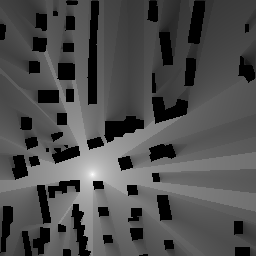

In [5]:
Image.open(input_image_pth).convert("L")

In [22]:
img_pillow = Image.open(input_image_pth).convert('RGB')
mask = Image.open(input_image_pth).convert("L")
img_256 = tfs(img_pillow)  
img_64 = tfs_64(img_pillow)

# mask_256 = mask_tfs_256(mask)
# mask_64 = mask_tfs_64(mask)
mask = np.array(mask)
antenna_mask = mask.copy()
mask[mask==255] =0  #3....don't set antenna to mask ,so comment this line

mask[mask > 0] = 1 #1为掩码区
mask= torch.tensor(np.expand_dims(mask, axis=0))  # 添加新维度，变为 (1, H, W)  #mask 是图片的掩码。掩码区域为1.。。...

In [23]:
torch.min(mask), torch.max(mask)

(tensor(0, dtype=torch.uint8), tensor(1, dtype=torch.uint8))

In [24]:
def generate_heatmap(H, W, x_norm, y_norm, sigma):  #生成高斯热图.....
    # 生成网格坐标
    y_indices, x_indices = torch.meshgrid(
        torch.arange(H, dtype=torch.float32),
        torch.arange(W, dtype=torch.float32),
        indexing='xy'  #这里要用xy,不能用ij....
    )
    heatmap = torch.exp(
        -((x_indices - x_norm)**2 + (y_indices - y_norm)**2) / (2 * sigma**2)
    )
    # 归一化到 [0, 1]
    heatmap = heatmap / heatmap.max()
    return heatmap  # 形状 (H, W)

In [25]:


gaussain_sigma = 5 #60-10-5-2-1-1.5...
print(np.argwhere(antenna_mask==np.max(antenna_mask)))
indicies = np.argwhere(antenna_mask==255)[0]
x_norm, y_norm = indicies[0] , indicies[1]
heatmap = generate_heatmap(256, 256, x_norm, y_norm, gaussain_sigma) #添加高斯热图
cond_image_0 = img_256*(1. - mask) + mask*torch.randn_like(img_256)   #  *0.999   # 3.....  # 去掉随机噪声看看
cond_image = cond_image_0 + heatmap  # # 256x256的条件图像
downsample = transforms.Resize((64, 64), interpolation=transforms.InterpolationMode.NEAREST)  # 下采样到64x64
cond_image_64 = downsample(cond_image) # 64x64的条件图像
mask_64 = downsample(mask)  # 64x64的掩码

[[174  92]]


#### 1.可视化图片是否正确

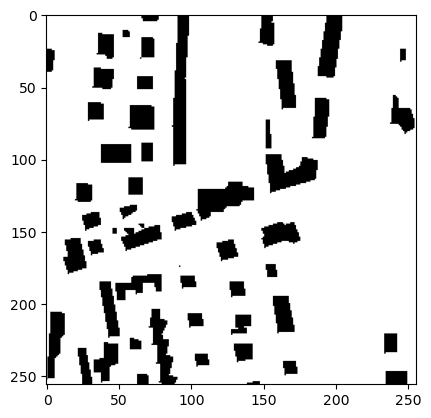

In [26]:
import matplotlib.pyplot as plt
plt.imshow(mask.squeeze().cpu().numpy(), cmap='gray')
plt.show()

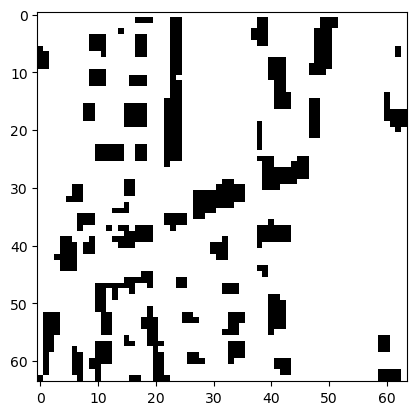

In [15]:
import matplotlib.pyplot as plt
plt.imshow(mask_64.squeeze().cpu().numpy(), cmap='gray')
plt.show()

In [12]:
torch.min(mask)

tensor(0, dtype=torch.uint8)

In [28]:
cond_image.shape

torch.Size([3, 256, 256])

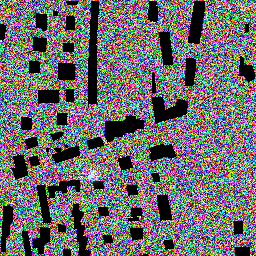

In [29]:
Image.fromarray(tensor2img(cond_image))

In [30]:
torch.min(mask[0])

tensor(0, dtype=torch.uint8)

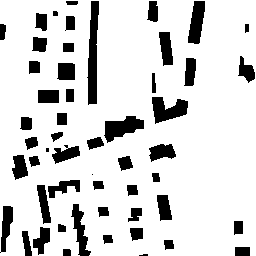

In [31]:
mask_np = mask[0].cpu().numpy().astype(np.uint8) * 255  # 缩放至 [0, 255]
Image.fromarray(mask_np, mode='L')  # 'L' 表示8位灰度图

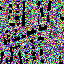

In [32]:
Image.fromarray(tensor2img(cond_image_64))

In [33]:
cond_image_64.shape

torch.Size([3, 64, 64])

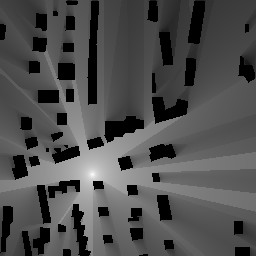

In [34]:
Image.fromarray(tensor2img(img_256))

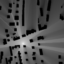

In [21]:
Image.fromarray(tensor2img(img_64))

In [22]:
#可视化完成，条件图像，真实图像，掩码图像下采样正确

In [13]:
# 转换回可显示的格式
def tensor_to_img(tensor, is_mask=False):
    if is_mask:
        return tensor.squeeze().numpy()
    else:
        # 反归一化并转换为numpy数组
        tensor = tensor * 0.5 + 0.5  # 从[-1,1]转回[0,1]
        return tensor.permute(1, 2, 0).numpy()
    


array = (tensor_to_img(img_256) * 255).astype(np.uint8)
img = Image.fromarray(array)

In [19]:
mask.shape

(256, 256)

In [17]:
Image.fromarray(tensor_to_img(img_256))

TypeError: Cannot handle this data type: (1, 1, 3), <f4

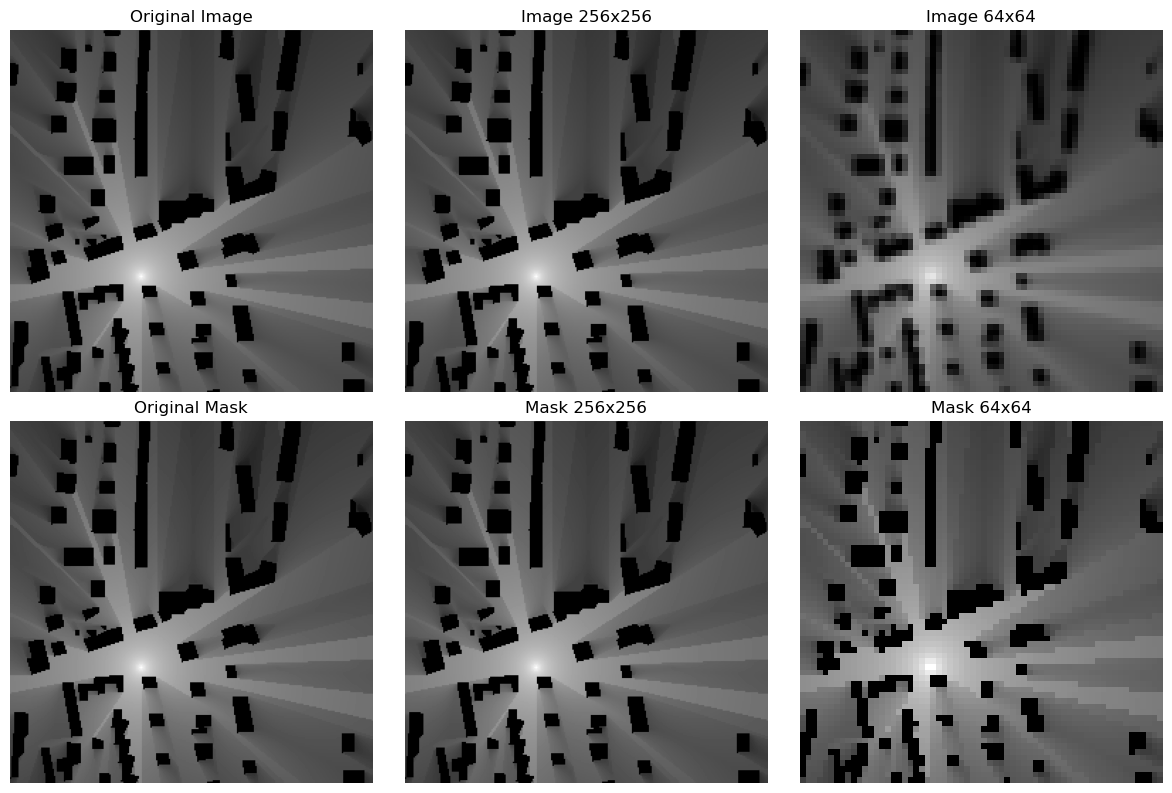

In [16]:
import matplotlib.pyplot as plt
# 显示结果
plt.figure(figsize=(12, 8))

plt.subplot(2, 3, 1)
plt.imshow(img_pillow)
plt.title("Original Image")
plt.axis('off')

plt.subplot(2, 3, 2)
plt.imshow(tensor_to_img(img_256))
plt.title("Image 256x256")
plt.axis('off')

plt.subplot(2, 3, 3)
plt.imshow(tensor_to_img(img_64))
plt.title("Image 64x64")
plt.axis('off')

plt.subplot(2, 3, 4)
plt.imshow(mask, cmap='gray')
plt.title("Original Mask")
plt.axis('off')

plt.subplot(2, 3, 5)
plt.imshow(tensor_to_img(mask_256, is_mask=True), cmap='gray')
plt.title("Mask 256x256")
plt.axis('off')

plt.subplot(2, 3, 6)
plt.imshow(tensor_to_img(mask_64, is_mask=True), cmap='gray')
plt.title("Mask 64x64")
plt.axis('off')

plt.tight_layout()
plt.show()

###### 验证

In [17]:
import torch
import torch.nn.functional as F
from torchvision import transforms
from PIL import Image
import numpy as np
import argparse
import numpy as np
import core.praser as Praser
import torch
from core.util import set_device, tensor2img
from data.util.mask import get_irregular_mask
from models.network import Network
from PIL import Image
from torchvision import transforms
import random
def set_deterministic(seed=42):
    """设置所有随机种子和确定性配置"""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_deterministic(42)  # 在代码最开头调用
tfs = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

tfs_64 = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])
def generate_heatmap(H, W, x_norm, y_norm, sigma):  #生成高斯热图.....
    # 生成网格坐标
    y_indices, x_indices = torch.meshgrid(
        torch.arange(H, dtype=torch.float32),
        torch.arange(W, dtype=torch.float32),
        indexing='xy'  #这里要用xy,不能用ij....
    )
    heatmap = torch.exp(
        -((x_indices - x_norm)**2 + (y_indices - y_norm)**2) / (2 * sigma**2)
    )
    # 归一化到 [0, 1]
    heatmap = heatmap / heatmap.max()
    return heatmap  # 形状 (H, W)

In [18]:

input_image_pth = "/home/y/project/dm/Palette-Image-to-Image-Diffusion-Models/g_image/GT_682_34.png"
img_pillow = Image.open(input_image_pth).convert('RGB')
mask = Image.open(input_image_pth).convert("L")
img_256 = tfs(img_pillow)  #，tensor
img_64 = tfs_64(img_pillow) #，tensor


mask = np.array(mask)
antenna_mask = mask.copy()
mask[mask==255] =0  #3....don't set antenna to mask ,so comment this line

mask[mask > 0] = 1 #1为掩码区
mask= torch.tensor(np.expand_dims(mask, axis=0))  # 添加新维度，变为 (1, H, W)  #mask 是图片的掩码。掩码区域为1.。。...，tensor


In [17]:
torch.min(mask)

tensor(0, dtype=torch.uint8)

In [43]:

gaussain_sigma = 5 #60-10-5-2-1-1.5...
print(np.argwhere(antenna_mask==np.max(antenna_mask)))
indicies = np.argwhere(antenna_mask==255)[0]
x_norm, y_norm = indicies[0] , indicies[1]
heatmap = generate_heatmap(256, 256, x_norm, y_norm, gaussain_sigma) #添加高斯热图
cond_image_0 = img_256*(1. - mask) + mask*torch.randn_like(img_256)   #  *0.999   # 3.....  # 去掉随机噪声看看
cond_image = cond_image_0 + heatmap  # # 256x256的条件图像，tensor
downsample = transforms.Resize((64, 64), interpolation=transforms.InterpolationMode.NEAREST)
cond_image_64 = downsample(cond_image) # 64x64的条件图像，tensor
mask_64 = downsample(mask)  # 64x64的掩码，tensor

[[174  92]]


In [44]:
print("mask's min value is ", mask.min())
print("mask's max value is ", mask.max())
print("mask_64's min value is ", mask_64.min())


mask's min value is  tensor(0, dtype=torch.uint8)
mask's max value is  tensor(1, dtype=torch.uint8)
mask_64's min value is  tensor(0, dtype=torch.uint8)


In [46]:
mask = torch.tensor([[-2.0, 0.5, 3.0]])  # 原始值
tensor2img(mask)                        # 调用函数
print(mask)                             # 输出: tensor([-1.0, 0.5, 1.0])，值被修改！

tensor([[-1.0000,  0.5000,  1.0000]])


In [47]:
from torchvision.utils import save_image

def save_tensor_safely(tensor, path, vmin=-1.0, vmax=1.0):
    """
    使用 torchvision 保存张量，不修改原始张量。
    """
    tensor = tensor.detach().clone().cpu()
    tensor_normalized = (tensor - vmin) / (vmax - vmin)
    save_image(tensor_normalized, path)

# 示例用法
save_tensor_safely(mask, "./result_m2s/mask_256.jpg")

### 数据纠正

In [1]:
import torch
import torch.nn.functional as F
from torchvision import transforms
from PIL import Image
import numpy as np
import argparse
import numpy as np
import core.praser as Praser
import torch
from core.util import set_device, tensor2img
from data.util.mask import get_irregular_mask
from models.network import Network
from PIL import Image
from torchvision import transforms
import random

In [6]:
tfs = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])
input_image_pth = "/home/y/project/dm/Palette-Image-to-Image-Diffusion-Models/g_image/GT_682_34.png"
def tensor_to_img(tensor, is_mask=False):
    if is_mask:
        return tensor.squeeze().numpy()
    else:
        # 反归一化并转换为numpy数组
        tensor = tensor * 0.5 + 0.5  # 从[-1,1]转回[0,1]
        return tensor.permute(1, 2, 0).numpy()
## 2. 图像生成


In [3]:
img_pillow = Image.open(input_image_pth).convert('RGB')
img_256 = tfs(img_pillow)  #，tensor

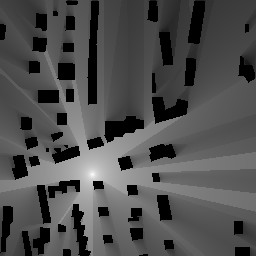

In [4]:
img_pillow

In [12]:
img_256_np = (tensor_to_img(img_256) * 255).astype(np.uint8)
print("img_256's shape is ", img_256_np.shape)
Image.fromarray(img_256_np).save("./result_m2s/img_256_1.jpg",quality=100)

img_256's shape is  (256, 256, 3)


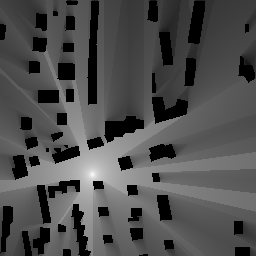

In [10]:
Image.fromarray(img_256_np)

#### 加噪检验

In [2]:
import torch
import torch.nn.functional as F
from torchvision import transforms
from PIL import Image
import numpy as np
import argparse
import numpy as np
import core.praser as Praser
import torch
from core.util import set_device, tensor2img
from data.util.mask import get_irregular_mask
from models.network import Network
from PIL import Image
from torchvision import transforms
import random
tfs = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])
input_image_pth = "/home/y/project/dm/Palette-Image-to-Image-Diffusion-Models/g_image/GT_682_34.png"
def tensor_to_img(tensor, is_mask=False):
    if is_mask:
        return tensor.squeeze().numpy()
    else:
        # 反归一化并转换为numpy数组
        tensor = tensor * 0.5 + 0.5  # 从[-1,1]转回[0,1]
        return tensor.permute(1, 2, 0).numpy()
## 2. 图像生成
img_pillow = Image.open(input_image_pth).convert('RGB')
img_256 = tfs(img_pillow)  #，tensor

In [3]:
img_256_np = (tensor_to_img(img_256) * 255).astype(np.uint8)
print("img_256's shape is ", img_256_np.shape)
Image.fromarray(img_256_np).save("./result_m2s/img_256_1.jpg",quality=100)

img_256's shape is  (256, 256, 3)


In [19]:
dd = img_256 + mask*torch.randn_like(img_256)*0.05


In [20]:
dd

tensor([[[-0.3939, -0.4158, -0.4452,  ..., -0.4933, -0.4963, -0.5104],
         [-0.5245, -0.4620, -0.5656,  ..., -0.5004, -0.5385, -0.4957],
         [-0.5505, -0.4805, -0.5207,  ..., -0.6017, -0.5431, -0.4928],
         ...,
         [-0.6479, -0.5585, -0.6022,  ..., -0.5471, -0.5305, -0.5367],
         [-0.5817, -0.4988, -0.4822,  ..., -0.5767, -0.5894, -0.5933],
         [-0.6307, -0.5414, -0.5564,  ..., -0.5326, -0.5741, -0.4719]],

        [[-0.4458, -0.3844, -0.6034,  ..., -0.6231, -0.5705, -0.5028],
         [-0.4548, -0.5057, -0.5345,  ..., -0.4984, -0.5484, -0.4864],
         [-0.4661, -0.6213, -0.3183,  ..., -0.4896, -0.5173, -0.5394],
         ...,
         [-0.6786, -0.5276, -0.5803,  ..., -0.6304, -0.5873, -0.4795],
         [-0.5760, -0.6446, -0.5309,  ..., -0.5918, -0.5058, -0.5335],
         [-0.4830, -0.5981, -0.4743,  ..., -0.5578, -0.5222, -0.5876]],

        [[-0.5693, -0.5232, -0.5223,  ..., -0.5833, -0.5777, -0.3893],
         [-0.4260, -0.5065, -0.4628,  ..., -0

In [21]:
print("原始张量形状:", dd.shape)  # 调试输出

# 确保张量是合理的图像形状
if dd.dim() == 4 and dd.shape[0] == 1:  # [1, C, H, W]
    dd = dd.squeeze(0)  # 移除 batch 维度 -> [C, H, W]
elif dd.dim() == 3 and dd.shape[0] == 1:  # [1, H, W]
    dd = dd.squeeze(0)  # 移除单通道 -> [H, W]
    
print("处理后形状:", dd.shape)  # 应该是 [C,H,W] 或 [H,W]

原始张量形状: torch.Size([3, 256, 256])
处理后形状: torch.Size([3, 256, 256])


In [24]:
def prepare_image_tensor(tensor, vmin=-1.0, vmax=1.0):
    """准备张量用于保存为图像"""
    # 1. 确保在CPU上且无梯度
    tensor = tensor.detach().cpu()
    
    # 2. 处理batch维度
    if tensor.dim() == 4:  # [B,C,H,W]
        tensor = tensor[0]  # 取第一张图
    
    # # 3. 归一化到[0,1]
    # tensor = (tensor - vmin) / (vmax - vmin)
    tensor = tensor*0.5 + 0.5  # 从[-1,1]转回[0,1]
    tensor = torch.clamp(tensor, 0, 1)
# 
    # 4. 转换为uint8并调整通道顺序
    if tensor.dim() == 3:  # [C,H,W]
        tensor = tensor.permute(1, 2, 0)  # [H,W,C]
    img_np = (tensor.numpy() * 255).astype(np.uint8)
    
    return img_np

# 使用示例
img_np = prepare_image_tensor(dd)

In [25]:
# 正确方式
img_np = prepare_image_tensor(dd)
Image.fromarray(img_np).save("./result_m2s/img_256_2.jpg", quality=100)

# # 或者使用OpenCV（更简单）
# import cv2
# cv2.imwrite("./result_m2s/img_256_2.jpg", cv2.cvtColor(img_np, cv2.COLOR_RGB2BGR), 
#             [int(cv2.IMWRITE_JPEG_QUALITY), 100])

True

### 3m

In [31]:
tfs = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])


In [32]:
img_pillow_256 = Image.open(input_image_pth).convert('RGB')
img_pillow_64 = img_pillow_256.resize((64, 64), Image.BICUBIC)  # 将输入图像下采样为64x64的大小

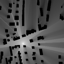

In [33]:
def generate_mask(image,size=64,):
    image = image

In [37]:
def preprocess_image(path,size=64):
    img_pillow = Image.open(path).convert('RGB')
    img_pillow = img_pillow.resize((size, size), Image.BICUBIC)  # 下采样
    tfs = transforms.Compose([
    transforms.Resize((size, size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ])
    img_tensor = tfs(img_pillow)  # 转换为张量并预处理
    mask = np.array(img_pillow.convert("L"))  # 将掩码图像转换为灰度图
    antenna_mask = mask.copy()
    max_value = antenna_mask.max()
    mask[mask==max_value] =0  
    mask[mask > 0] = 1 #1为掩码区
    mask= torch.tensor(np.expand_dims(mask, axis=0))  # 添加新维度，变为 (1, H, W)  #mask 是图片的掩码。掩码区域为1.。。...
    gaussain_sigma = 5 
    indicies = np.argwhere(antenna_mask==max_value)[0]
    print(indicies)
    x_norm, y_norm = indicies[0] , indicies[1]
    heatmap = generate_heatmap(size, size, x_norm, y_norm, gaussain_sigma) #添加高斯热图
    cond_image_0 = img_tensor*(1. - mask) + mask*torch.randn_like(img_tensor)  
    cond_image = cond_image_0 + heatmap   # 采样时必须要加heatmap,否则基站位置会漂移
    return img_tensor, mask, cond_image
img_tensor, mask, cond_image = preprocess_image(input_image_pth, size=64)


[[65 64 63 ... 60 61 61]
 [67 65 64 ... 61 61 62]
 [72 67 65 ... 62 62 60]
 ...
 [ 8 37 80 ... 56 64 72]
 [11 39 79 ...  0 29 69]
 [49 68 75 ...  0 25 59]]
234
[[False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]
 ...
 [False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]]


In [ ]:

img_pillow_256 = Image.open(input_image_pth).convert('RGB')
img_pillow_64 = img_pillow_256.resize((64, 64), Image.BICUBIC)  # 将输入图像下采样为64x64的大小
# 接下来对64进行操作
img = tfs(img_pillow_64)  # 对64x64的图像进行预处理
mask = np.array(img_pillow_64.convert("L"))  # 将掩码图像转换为灰度图
antenna_mask = mask.copy()
print(antenna_mask)
print(antenna_mask.max())
max_value = antenna_mask.max()
print(antenna_mask==max_value)
mask[mask==max_value] =0  #3....don't set antenna to mask ,so comment this line

mask[mask > 0] = 1 #1为掩码区
mask= torch.tensor(np.expand_dims(mask, axis=0))  # 添加新维度，变为 (1, H, W)  #mask 是图片的掩码。掩码区域为1.。。...
gaussain_sigma = 5 #60-10-5-2-1-1.5...
print(np.argwhere(antenna_mask==max_value))
print(mask)
indicies = np.argwhere(antenna_mask==max_value)
x_norm, y_norm = indicies[0][0] , indicies[0][1]
heatmap = generate_heatmap(64, 64, x_norm, y_norm, gaussain_sigma) #添加高斯热图
cond_image_0 = img*(1. - mask) + mask*torch.randn_like(img)   #  *0.999 # 采样时必须要加随机噪声,否则采样图片是掩码图片
cond_image = cond_image_0 + heatmap   # 采样时必须要加heatmap,否则基站位置会漂移


In [38]:
mask


array([[1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       ...,
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 0, 1, 1],
       [1, 1, 1, ..., 0, 1, 1]], dtype=uint8)

In [40]:
mask= torch.tensor(np.expand_dims(mask, axis=0))  # 添加新维度，变为 (1, H, W)  #mask 是图片的掩码。掩码区域为1.。。...
gaussain_sigma = 5 #60-10-5-2-1-1.5...
print(np.argwhere(antenna_mask==max_value))
print(mask)
indicies = np.argwhere(antenna_mask==max_value)
x_norm, y_norm = indicies[0][0] , indicies[0][1]
heatmap = generate_heatmap(64, 64, x_norm, y_norm, gaussain_sigma) #添加高斯热图
cond_image_0 = img*(1. - mask) + mask*torch.randn_like(img)   #  *0.999 # 采样时必须要加随机噪声,否则采样图片是掩码图片
cond_image = cond_image_0 + heatmap   # 采样时必须要加heatmap,否则基站位置会漂移



[[43 23]]
tensor([[[[1, 1, 1,  ..., 1, 1, 1],
          [1, 1, 1,  ..., 1, 1, 1],
          [1, 1, 1,  ..., 1, 1, 1],
          ...,
          [1, 1, 1,  ..., 1, 1, 1],
          [1, 1, 1,  ..., 0, 1, 1],
          [1, 1, 1,  ..., 0, 1, 1]]]], dtype=torch.uint8)


In [42]:
# save conditional image used a inference input
cond_image_np = cond_image.detach().float().cpu().numpy().squeeze()
cond_image_np = (cond_image_np* 255).astype(np.uint8)  # 从[-1,1]转回[0,255]
cond_image_np = np.transpose(cond_image_np, (1, 2, 0))  # 转换为(H, W, C)格式
Image.fromarray(cond_image_np).save("./result/cond_image.jpg",quality=100)

mask_np = mask.detach().float().cpu().numpy()
mask_np = mask_np.squeeze()  # 去掉batch维度
mask_np = (mask_np * 255).astype(np.uint8)  # 从[0,1]转回[0,255]
Image.fromarray(mask_np, mode='L').save("./result/mask.jpg",quality=100)
# set device